In [1]:

from torch_geometric.data import Data
import numpy as np
from torch.nn.functional import normalize, relu, sigmoid
from torch.nn import Linear, init
import torch
from torch import Tensor as T
from torch.nn import ModuleList
%load_ext autoreload
%autoreload 2

In [2]:

from gnn_tracking.graph_construction.radius_scanner import construct_graph
from gnn_tracking.models.mlp import MLP

In [3]:
# class GCWithGeometricEF:
#     def __init__(self, ef, radius: float = 1,
#             max_num_neighbors: int = 256,):
#         self._ef = ef
#         self._radius = radius
#         self._max_num_neighbors = max_num_neighbors
#
#     def __call__(self, data: Data):
#         edge_index = radius_graph(data.x, self._radius, max_num_neighbors=self._max_num_neighbors)
#         data.edge_index = edge_index
#         mask = self._ef(data)
#         data.edge_index = data.edge_index[mask]


In [4]:
from gnn_tracking.utils.log import logger
from torch_cluster import radius_graph




In [5]:
from gnn_tracking.utils.loading import TrackingDataset, get_loaders
from pathlib import Path
graph_dir = Path("")

datasets = {
    "train": TrackingDataset([Path(f"/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_{i}") for i in range(1,9)]),
    "val": TrackingDataset(Path("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9"), stop=10),
}
loaders = get_loaders(datasets, max_sample_size=1000)

[19:34:35] INFO: DataLoader will load 7743 graphs (out of 7743 available).
[19:34:35] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_8/data28999_s0.pt
[19:34:35] INFO: DataLoader will load 10 graphs (out of 1000 available).
[19:34:35] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29009_s0.pt
[19:34:35] DEBUG: Parameters for data loader 'train': {'batch_size': 1, 'num_workers': 1, 'sampler': <torch.utils.data.sampler.RandomSampler object at 0x147f2a27dfc0>, 'pin_memory': True, 'shuffle': None}
[19:34:35] DEBUG: Parameters for data loader 'val': {'batch_size': 1, 'num_workers': 1, 'sampler': None, 'pin_memory': True, 'shuffle': False}


In [6]:
datasets["val"][0]

Data(x=[59357, 14], edge_index=[2, 203759], y=[0], layer=[59357], particle_id=[59357], pt=[59357], reconstructable=[59357], sector=[59357])

In [7]:
from gnn_tracking_hpo.restore import restore_model
from gnn_tracking_hpo.trainable import GCTrainable

gc_model = restore_model(GCTrainable, run_hash="7dce6aff", tune_dir="gc-hinge-sq-sq-cells", freeze=True)

[19:34:37 HPO] INFO: Initializing pre-trained model
[19:34:37 HPO] DEBUG: Loading config from /home/kl5675/ray_results/gc-hinge-sq-sq-cells/GCTrainable_7dce6aff_24_val_batch_size=1,adam_amsgrad=False,adam_beta1=0.9000,adam_beta2=0.9990,adam_eps=0.0000,adam_weight_decay=_2023-06-08_13-32-02/params.json
[19:34:37 HPO] INFO: I'm running on a node with job ID=48386227
[19:34:37 HPO] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[19:34:37 HPO] INFO: The ID of my dispatcher is 0
[19:34:37 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[19:34:37 HPO] DEBUG: Got config
┌───────────────────────────────┬──────────────────────────────────────────┐
│ _no_data                      │ True                                     │
│ _val_batch_size               │ 1                                        │
│ adam_amsgrad                  │ False                                    │
│ adam_beta1     

In [8]:
def build_random_graph(data):
    device = data.edge_index.device
    true_edge = data.edge_index
    random_edges = torch.randint(
        0, data.num_nodes, (2, data.num_edges), device=device
    )
    data.y = torch.cat((
        torch.full((true_edge.shape[1],), 1, dtype=torch.float, device=device),
        torch.full((random_edges.shape[1],), 0, dtype=torch.float, device=device),
    ))
    data.edge_index = torch.cat([true_edge, random_edges], dim=1)

In [9]:
from gnn_tracking.models.edge_classifier import ECForGraphTCN

ec = ECForGraphTCN(node_indim=14+8, edge_indim=(14+8)*2, interaction_edge_dim=64, interaction_node_dim=64, hidden_dim=64, L_ec=4, use_intermediate_edge_embeddings=False, use_node_embedding=True,)

In [10]:
from gnn_tracking.metrics.losses import EdgeWeightBCELoss, EdgeWeightFocalLoss, \
    HaughtyFocalLoss
from gnn_tracking.training.tcn_trainer import TCNTrainer

trainer = TCNTrainer(
    model=GCWithEF(
        ml=gc_model,
        ef=ec,#EFMLP(in_dim=14+8, hidden_dim=128, depth=6),
        radius=0.7,
        max_num_neighbors=64,
        use_embedding_features=True,
        ratio_of_false=None,
        build_edge_features=True,
    ),
    loaders=loaders,
    loss_functions={"edge": (HaughtyFocalLoss(alpha=0.5, gamma=0, pt_thld=0.9), 1.)},
    lr=1e-3,
)

NameError: name 'GCWithEF' is not defined

In [ ]:
trainer.train(epochs=10)

In [13]:


from gnn_tracking.metrics.binary_classification import BinaryClassificationStats

for i, data in enumerate(loaders["val"]):
    if i > 5:
        break
    latent = gc_model(data.to("cuda"))["H"]
    edge_index = radius_graph(latent, r=1, max_num_neighbors=256)
    y = (data.particle_id[edge_index[0]] == data.particle_id[edge_index[1]])
    print(f"n edges: {edge_index.shape[1]}, true: {y.sum()}, false: {(~y).sum()}")
    data.edge_index = edge_index
    mask = GeometricEF(z0_max=1e6, dR_max=1e6, phi_slope_max=1e6)(data)
    s = BinaryClassificationStats(mask.float(), y.long(), thld=0.5)
    print(s.get_all())
    break

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


n edges: 7837250, true: 413704, false: 7423546
{'acc': 0.05321815687900731, 'TPR': 0.9997824531549127, 'TNR': 0.00046743160209420135, 'FPR': 0.9995325683979058, 'FNR': 0.0002175468450873088, 'balanced_acc': 0.5001249423785035, 'F1': 0.10030174379931406, 'MCC': 0.002622298564743843, 'n_true': 413704, 'n_false': 7423546, 'n_predicted_true': 7833690, 'n_predicted_false': 3560}


In [14]:
r = data.x[:, 0]
phi = data.x[:, 1]
z = data.x[:, 2]
eta = data.x[:, 3]
i = data.edge_index[0]
j = data.edge_index[1]
dz = z[i] - z[j]
dr = r[i] - r[j]
dphi = phi[i] - phi[j]
deta = eta[i] - eta[j]
dR = torch.sqrt(deta**2 + dphi **2)
phi_slope = dphi / dR
z0 = z[i] - r[i] * dz / dr

In [40]:
random = torch.rand(len(y), device="cuda")

In [41]:
random_mask = random < 0.05

In [42]:
y.sum(), (~y).sum()

(tensor(413704, device='cuda:0'), tensor(7423546, device='cuda:0'))

(array([1.59141645, 0.94012081, 0.67743994, 0.5656541 , 0.51441439,
        0.50179932, 0.54564253, 0.66380282, 0.93242848, 3.06728063]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

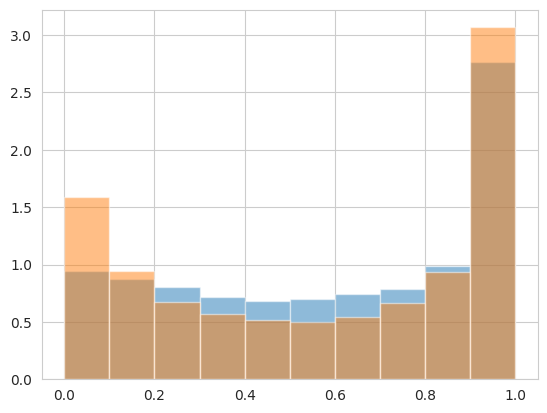

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(phi_slope[random_mask & y].abs().detach().cpu(), density=True, bins=10, alpha=0.5)
ax.hist(phi_slope[random_mask & ~y].abs().detach().cpu(), density=True, bins=10, alpha=0.5)

(array([3.14513508, 0.73896294, 0.2509966 , 0.14163345, 0.09227744,
        0.06053118, 0.03419579, 0.02155821, 0.01470931]),
 array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
        1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ]),
 <BarContainer object of 9 artists>)

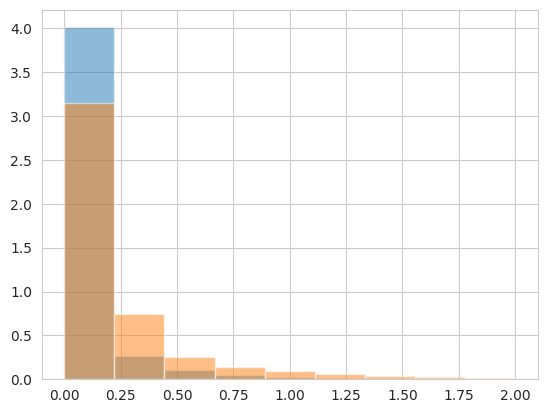

In [54]:
fig, ax = plt.subplots()
bins=np.linspace(0, 2, 10)
ax.hist(dR[random_mask & y].detach().cpu(), density=True, bins=bins, alpha=0.5)
ax.hist(dR[random_mask & ~y].detach().cpu(), density=True, bins=bins, alpha=0.5)

In [47]:
z0[random_mask].nanmin(), z0[random_mask].max()

AttributeError: 'Tensor' object has no attribute 'nanmin'

In [50]:
z0[torch.isfinite(z0)].min()

tensor(-8.0192e+08, device='cuda:0')

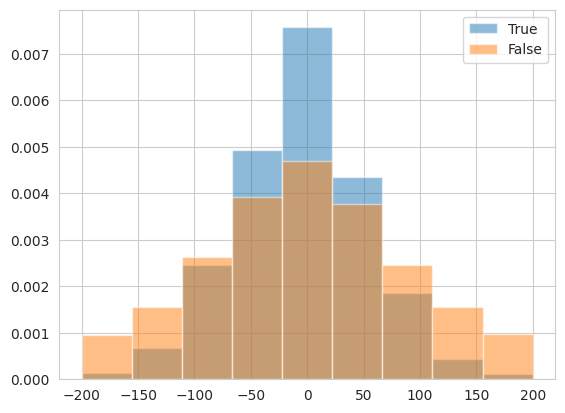

In [53]:
fig, ax = plt.subplots()
bins=np.linspace(-200, 200, 10)
ax.hist(z0[random_mask & y].detach().cpu(), density=True, bins=bins, alpha=0.5, label="True")
ax.hist(z0[random_mask & ~y].detach().cpu(), density=True, bins=bins, alpha=0.5, label="False")
ax.legend()

In [ ]:

mo = gc_trainable.trainer.evaluate_model(datasets["val"][0])

In [88]:
data_for_ef = construct_graph(mo, radius=0.8, max_num_neighbors=256)
data_for_ef.x = datasets["val"][0].x
data_for_ef.reconstructable = datasets["val"][0].reconstructable
data_for_ef.sector = datasets["val"][0].sector

In [89]:
ef_mo = trainer.evaluate_model(data_for_ef)

(array([  22324.,   14266.,   14592.,   17648.,   24314.,   39156.,
         112678.,  535270., 1224306., 2859920.]),
 array([5.85373833e-11, 9.99962837e-02, 1.99992567e-01, 2.99988836e-01,
        3.99985135e-01, 4.99981403e-01, 5.99977672e-01, 6.99973941e-01,
        7.99970269e-01, 8.99966538e-01, 9.99962807e-01]),
 <BarContainer object of 10 artists>)

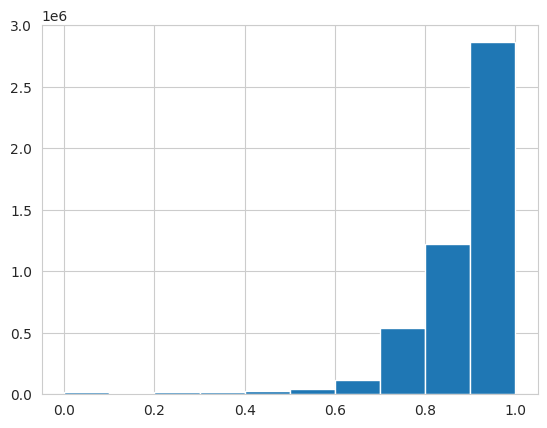

In [97]:
from matplotlib import pyplot as plt

plt.hist(ef_mo["w"].detach().cpu().numpy())

In [93]:
trainer.evaluate_ec_metrics_with_pt_thld(ef_mo, 0.9, 0.5)

{'acc_pt0.9': 0.0965054044763815,
 'TPR_pt0.9': 0.9975925336727118,
 'TNR_pt0.9': 0.02026915776151404,
 'FPR_pt0.9': 0.9797308422384859,
 'FNR_pt0.9': 0.0024074663272881536,
 'balanced_acc_pt0.9': 0.5089308457171129,
 'F1_pt0.9': 0.14694588514653503,
 'MCC_pt0.9': 0.03519922938978789,
 'n_true_pt0.9': 377160,
 'n_false_pt0.9': 4457906,
 'n_predicted_true_pt0.9': 4743800,
 'n_predicted_false_pt0.9': 91266,
 'max_ba_pt0.9': 0.6116210337271276,
 'max_ba_loc_pt0.9': 0.9346733689308167,
 'max_f1_pt0.9': 0.19848486336811752,
 'max_f1_loc_pt0.9': 0.9497487545013428,
 'max_mcc_pt0.9': 0.12080150631042134,
 'max_mcc_loc_pt0.9': 0.9396985173225403,
 'tpr_eq_tnr_pt0.9': 0.6102698850438107,
 'tpr_eq_tnr_loc_pt0.9': 0.9396985173225403,
 'roc_auc_pt0.9': 0.6472032070159912,
 'roc_auc_0.001FPR_pt0.9': 0.5004794597625732,
 'roc_auc_0.01FPR_pt0.9': 0.5051791667938232,
 'roc_auc_0.1FPR_pt0.9': 0.530479371547699}